#Bank Churn Prediction

###Background and Context

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

###Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

###Data Dictionary

- CustomerId: Unique ID which is assigned to each customer
- Surname: Last name of the customer 
- CreditScore: It defines the credit history of the customer.  
- Geography: A customer’s location    
- Gender: It defines the Gender of the customer   
- Age: Age of the customer     
- Tenure: Number of years for which the customer has been with the bank
- NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
- Balance: Account balance
- HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
- EstimatedSalary: Estimated salary 
- isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
- Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
                    0=No ( Customer did not leave the bank )

                    1=Yes ( Customer left the bank )



#Import Libraries

In [306]:
import numpy as np
import pandas as pd

In [307]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [308]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras

In [309]:
from sklearn import model_selection, metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from tensorflow.keras import losses, optimizers, Sequential, backend, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import random
import time

#Import Data

In [310]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [311]:
data = pd.read_csv('/content/drive/MyDrive/Python Course/Churn.csv')

In [312]:
df = data.copy()

# Data Overview

In [313]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


- data imported succesfully

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- Our data has 10,000 rows and 14 columns (13 independent feature columns and 1 target variable column)
- There are 3 object type variable columns and 11 numerical columns of which 2 contain float type variables while the other 9 are integets
- Each column shows a count of 10,000 non-null values so it doesn't appear we have any missing data.

In [315]:
df.duplicated().sum()

0

- There are not any duplicated entries in our dataset

In [316]:
df.describe().T.applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.00,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00
CustomerId,10000.00,15690940.57,71936.19,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00
CreditScore,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,10000.00,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
NumOfProducts,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48


- Mean age is approx. 39, while max age will probably appear as outlier, being 92 is quite old compared to the average customer age.
- Average tenure, or years with the bank, is 5 years with a max of 10. So no customers in the dataset have been with the bank longer than 10 years.
- Mean balance is somewhat high at approx. 76,500 but the range is very wide as it spans from a 0 balance to as high as over 250,000. This means that we are likely to see outliers on both ends of the spectrum.
- Average number of bank products owned by customers is 1.5 while max is 4 products.
- Estimated salary shows over 100,000 for the average but interestingly a minimum estimated salary of 11.58 which seems very unlikely to be a salary but again it is only an estimate and we are not sure how they are reaching that estimate. With cutomers as young as 18 and some customers balance being 0, I guess it could be possible for an algorithm of some kind to estimate such a low salary. This will likely be an outlier being so far from the average. 

In [317]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

- We can see from this that both 'RowNumber' and 'CustomerID' are simply identifiers so we can drop these as they will not be necessary for our model.

- 'EstimatedSalary' only has 2 customers with the same estimated salary out of our 10,000 customer dataset. This confirms what we suspected with salary being estimated down to the penny.

In [318]:
df.drop(['RowNumber', 'CustomerId'], axis=1, inplace=True)

'Surname'  ia not distinguishing factor for determining if someone will leave the bank or not for our model, therefore we will drop it as well.

In [319]:
df.drop(['Surname'], axis=1, inplace=True)

In [320]:
df.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1


- 'RowNumber', 'CustomerId', and 'Surname' have been successfully dropped

In [321]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

- 'Exited' is our target variable, which the value counts show as being unbalanced.
- Over twice as many customers in the dataset are still with the bank, as opposed to those who have left the bank.

#EDA

###Univariate Analysis

In [322]:
# function for boxplot and a histogram on combined scale

def hist_box(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    Data: df
    feature: df column
    figsize: default(12,7)
    kde: show density curve (defualt False)
    bins: bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={'height_ratios': (0.25, 0.75)},
        figsize=figsize
    )
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color='orange'
    )
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette='winter'
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2 
    )
    ax_hist2.axvline(
        data[feature].mean(), color='green', linestyle='--'
    )
    ax_hist2.axvline(
        data[feature].median(), color='black', linestyle='-'
    )

###Credit Score

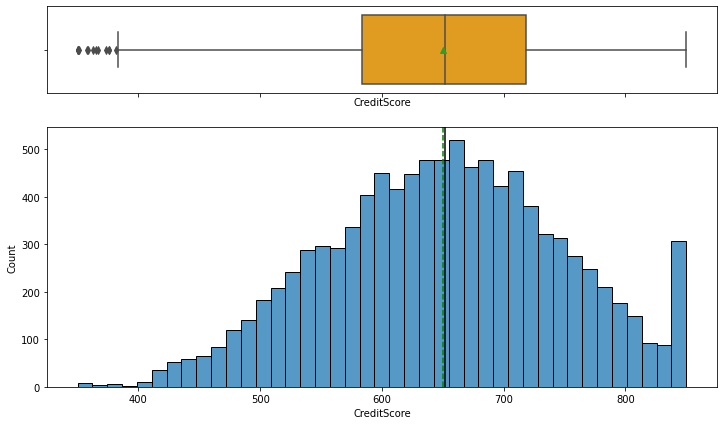

In [323]:
hist_box(df, 'CreditScore')

- Credit score has a slight left skew due to outliers on the low side below a 400 credit score.
- The count of customers seems to steadily decline past s mid 600 credit score, but then there is a high spike of over 300 customers at the max value of an 850 credit score.

###Age

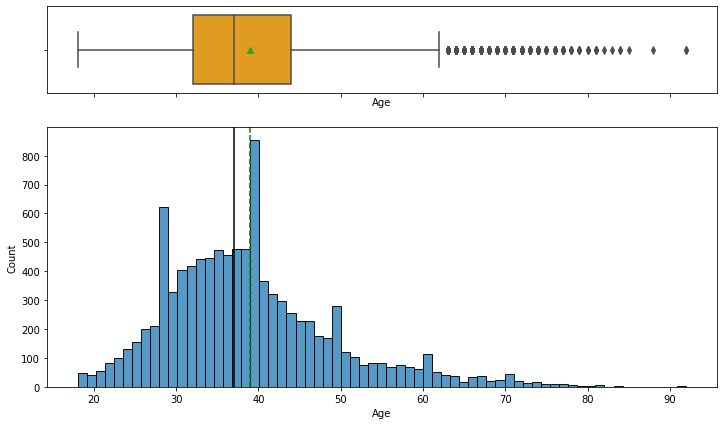

In [324]:
hist_box(df, 'Age')

- Age has a significant right skew with any age over 60 being considered an outlier as far as age goes.
- We can see here that the max age of 92 is indeed an extreme outlier.

###Tenure

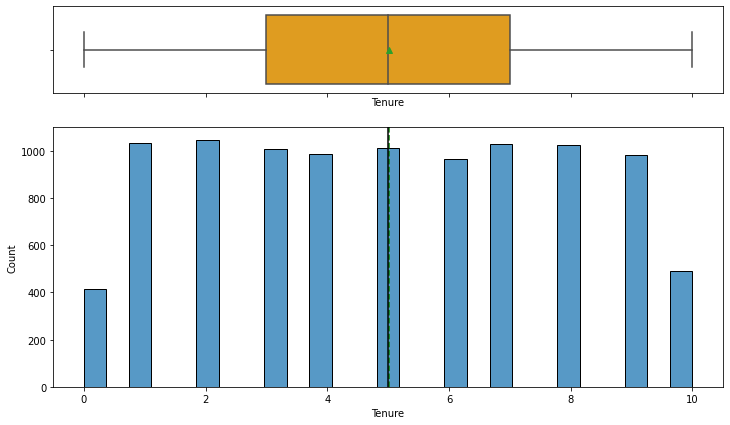

In [325]:
hist_box(df, 'Tenure')

- Tenure has a somewhat even distribution across the years with a smaller number at the min. and max compared to the other tenure lengths in years.
- The mean and median both sit in the dead center at a 5 year tenure length.

###Number of Products

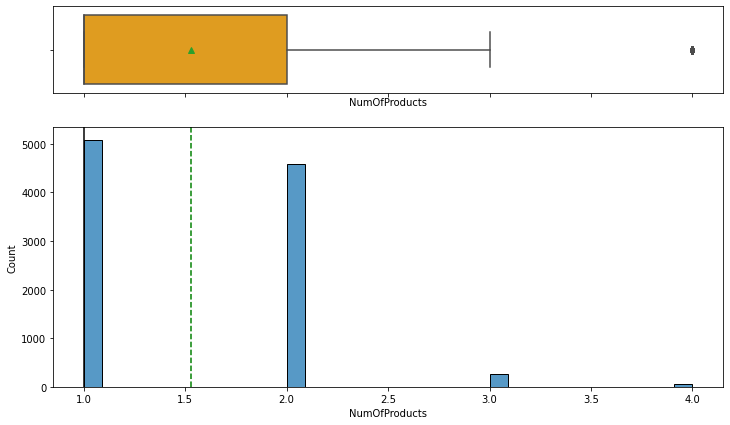

In [326]:
hist_box(df, 'NumOfProducts')

- It would seem the largest portion of customers only have 1 bank product. Two products is the next highest category with almost as many customers as those with 1 product.
- Only a samll number of customers have 3 or 4 bank products, with 4 products being considered an outlier.

###Balance

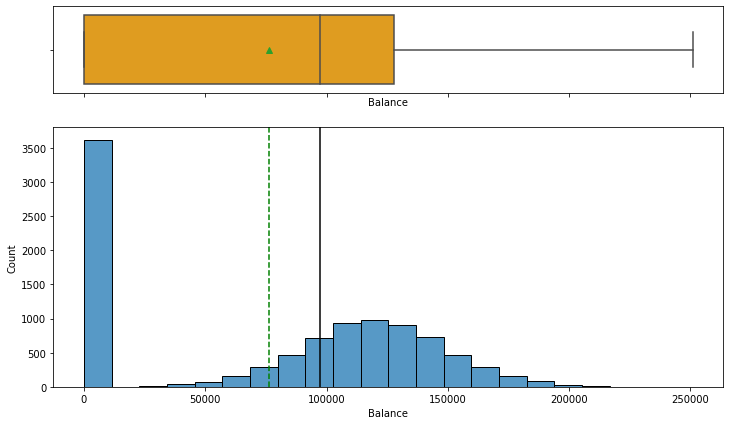

In [327]:
hist_box(df, 'Balance')

- A little over a third of customers have a 0 balance which is quite surpring given that the average balance was around 76,500.
- Surprisingly no balance amounts are considered outliers, even with a range of 0 to 250,000.

### Has Credit Card

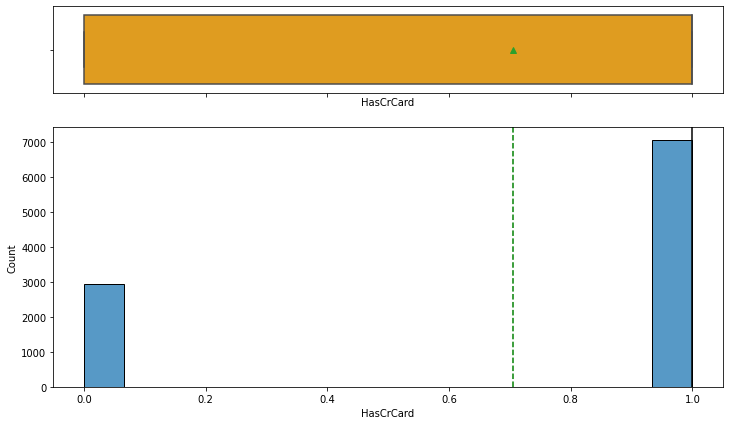

In [328]:
hist_box(df, 'HasCrCard')

- A little over two thirds of customers have a credit card with the bank.

### Estimated Salary

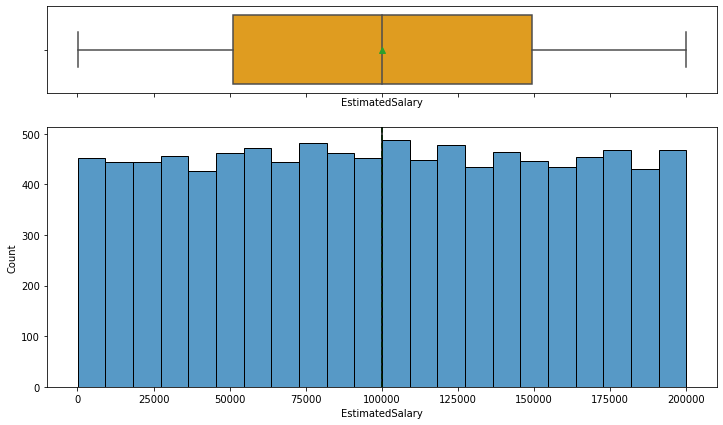

In [329]:
hist_box(df, 'EstimatedSalary')

- Estimated salary has a pretty even distribution across the whole estimated salary range.
- There are no outliers despite an estimated salary range extending from as low as 11.85 up to nearly 200,000.

###Is Active Member

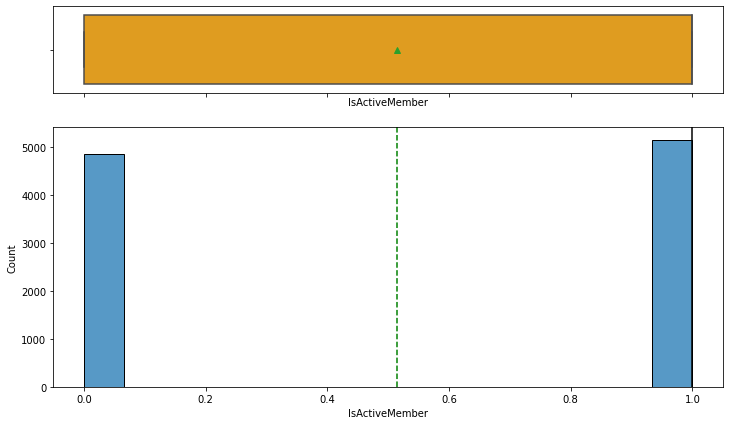

In [330]:
hist_box(df, 'IsActiveMember')

- Only slightly over half of the customers are considered active members. This might be why the bank is wanting to try and predict whether or not a customer will leave, as having this many inactive customers can not be good for business.

###Exited

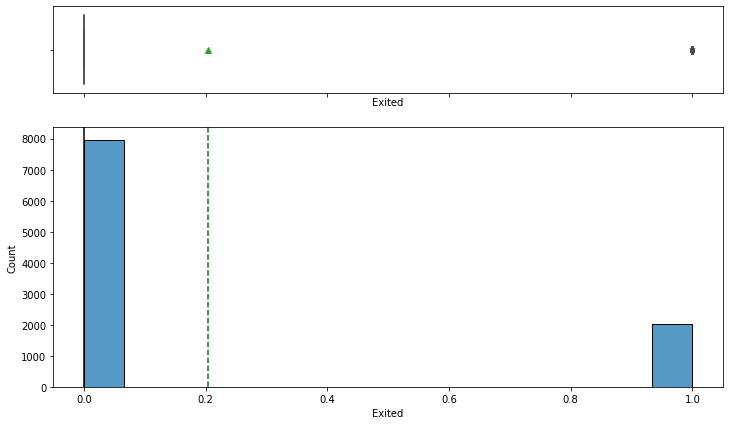

In [331]:
hist_box(df, 'Exited')

- Although there is a high number of inactive members, less than a fourth of customers in the dataset actually left the bank.
- This result tells us that the target variable in our dataset is imbalanced. We will need to account for this when developing our models.

In [332]:
# function for labeled barplot

def label_bar(data, feature, perc=False, n=None):
    """
    Barplot with percentage

    data: df
    feature: df column
    perc: display percentages instead of count (default is False)
    n: top n category levels (default is None)
    """

    total = len(data[feature])
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.gifure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette='Paired',
        order=data[feature].value_counts().index[:n].sort_values()
    )

    for p in ax.patches:
        if perc == True:
            label = '{:.1f}%'.format(
                100 * p.get_height() / total
            )
        else:
            label = p.get_height()

        x = p.get_x() + p.get_width() / 2
        y = p.get_height()

        ax.annotate(
            label,
            (x,y),
            ha='center',
            va='center',
            size=12,
            xytext=(0,5),
            textcoords='offset points'
        )

    plt.show()

###Geography

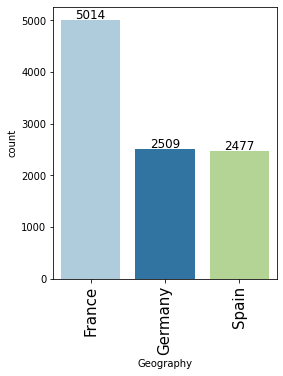

In [333]:
label_bar(df, 'Geography')

- Slightly over half of the customers are from France.
- The other half are split almost evenly between Germany and Spain.

###Gender

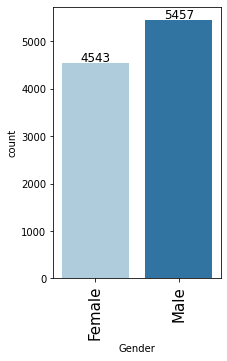

In [334]:
label_bar(df, 'Gender')

- There are more male customers than female, but overall not a significant difference in our dataset.

###Exited Proportions

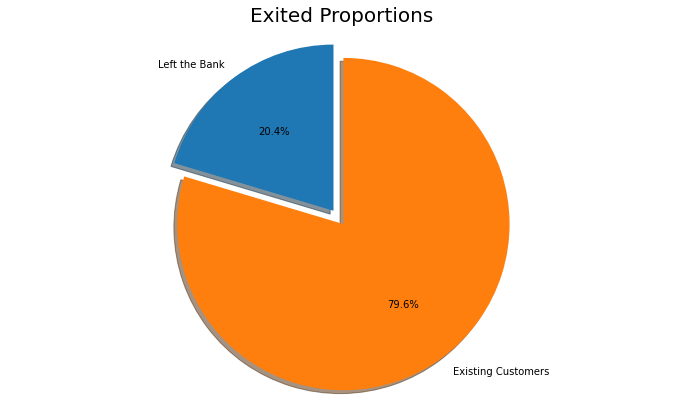

In [335]:
# function to create a pie chart showing proportions for our target variable, 'Exited'
labels = 'Left the Bank', 'Existing Customers'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Exited Proportions', size=20)
plt.show()

- This pie chart helps to better visualize how imbalanced the classes are for our target variable, 'Exited'.
- Only about 20% of the customers in our dataset have left the bank

#Bivariate Analysis

In [336]:
# Function to plot distribution and boxplot of features as compared to our taget variable, 'Exited'

def dist_plot_with_exited(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(16,10))

    target_uniq = df[target].unique()

    axs[0, 0].set_title("Distribution for Customers who Exited: ['Exited'] = " + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color='Blue'
    )

    axs[0, 1].set_title("Distribution for Existing Customers: ['Exited'] = " + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color='Orange'
    )

    axs[1, 0].set_title("Boxplot w.r.t. ['Exited']")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1,0], palette='gist_rainbow')

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t. ['Exited']")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette='gist_rainbow',
    )

    plt.tight_layout()
    plt.show()

###Credit Score vs. Exited

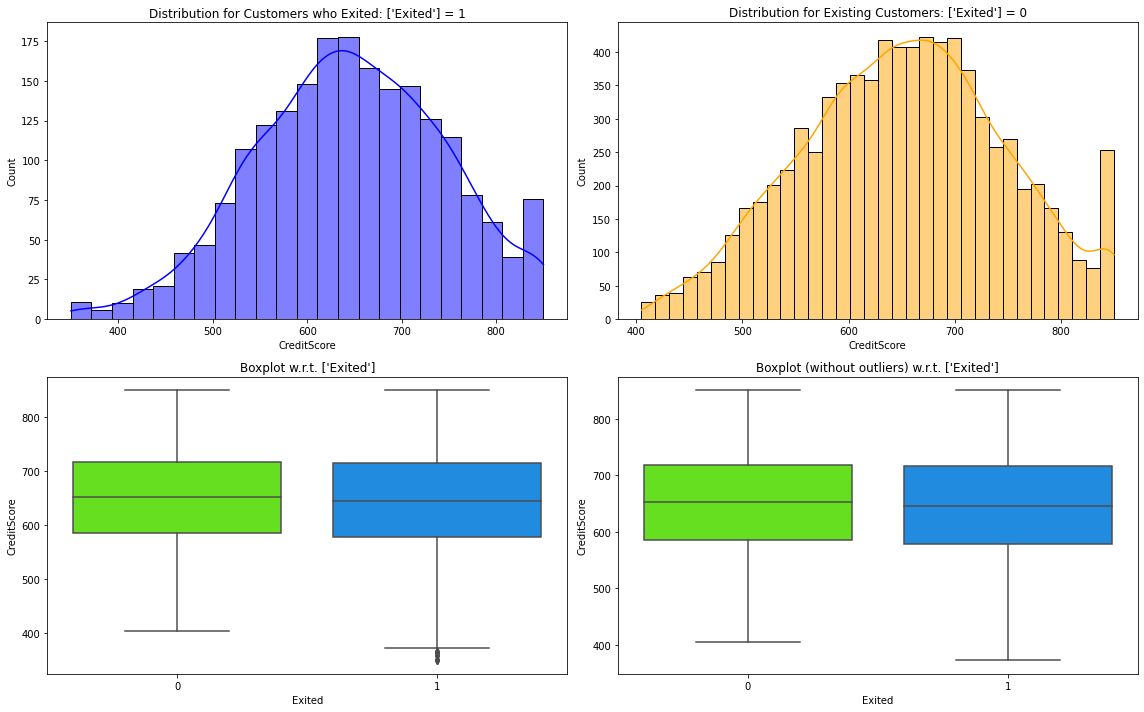

In [337]:
dist_plot_with_exited(df, 'CreditScore', 'Exited')

- The distributions for both existing customers and those who left is fairly similar with respect to credit score.  Both are slightly left skewed, and both show a steady decrease in customers past the mid 600s in credit score, with a larger spike at he max value of 850. Both are comparable to the combined distribution we saw earlier in our univariate analysis.
- One bigger difference is that only those who left the bank have outliers on the low end with respect to credit score. It seems less than 400 is considered an outlier, while there are no existing customers with less than a 400 credit score.

###Age vs. Exited

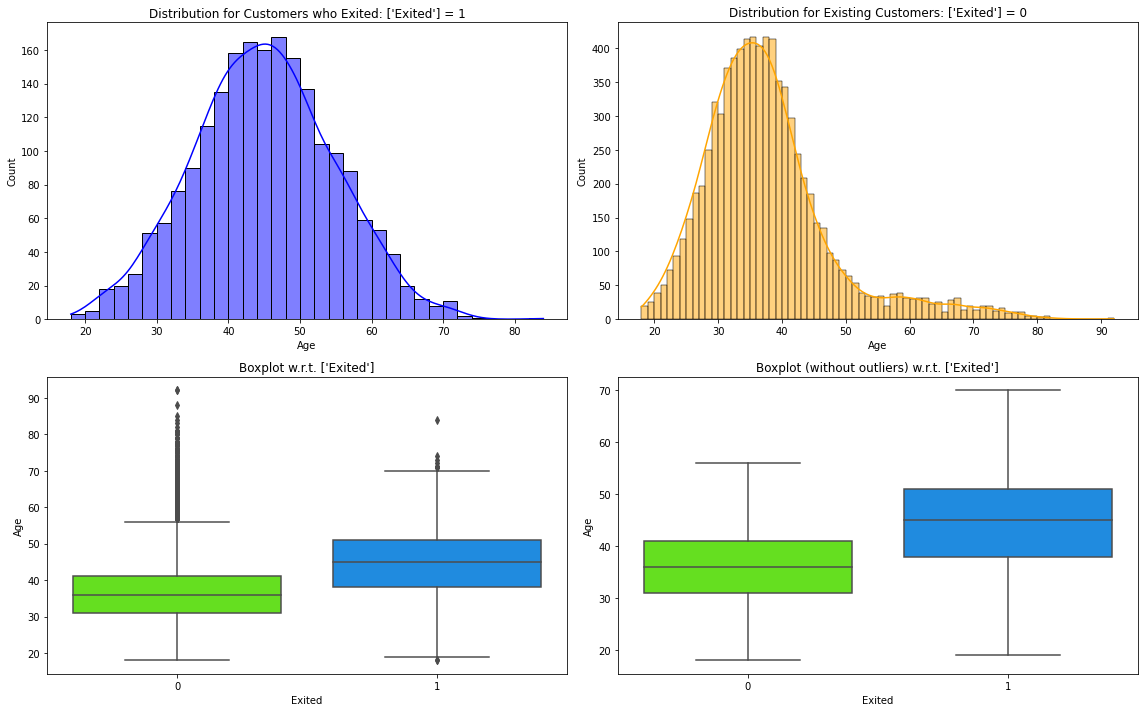

In [338]:
dist_plot_with_exited(df, 'Age', 'Exited')

- Customers who exited have a fairly normal distribution when it comes to Age. There are outliers on both the low and high ends.
- Existing Customers have a much more right skewed distribution. The age range of 60 and above are considered outliers for existing customers. 
- The distribution of existing customers is shifted more towards a younger age range as compared to those who left the bank which has a much more even distribution with respect to age range.

###Tenure vs. Exited

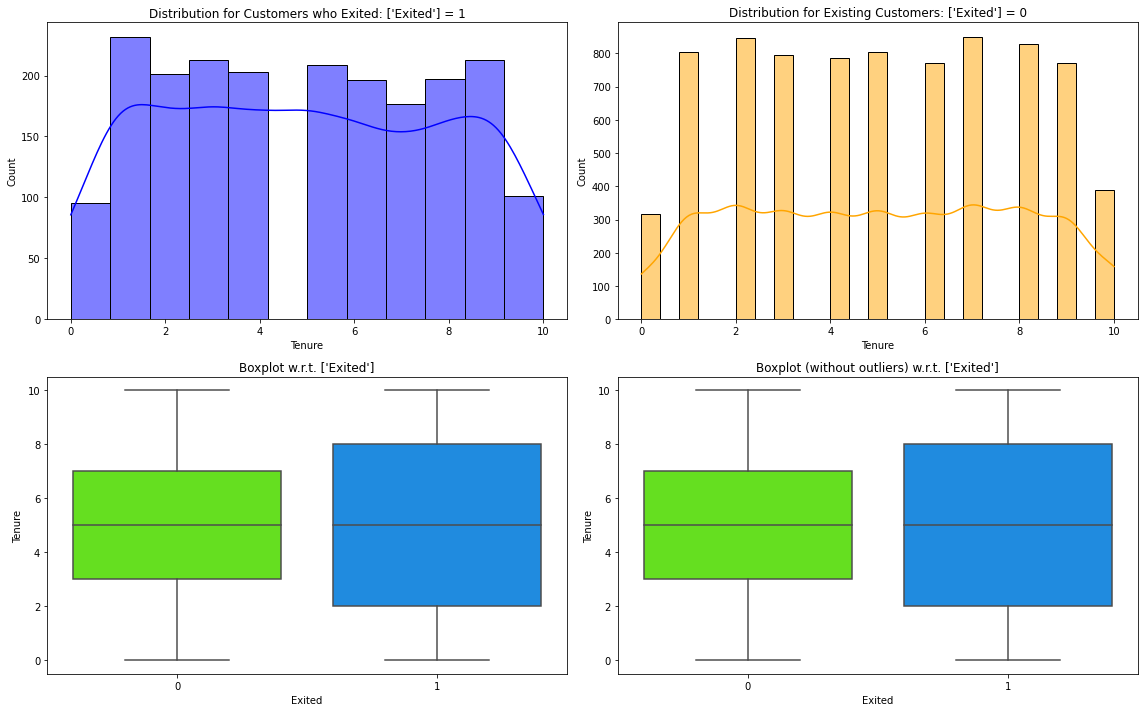

In [339]:
dist_plot_with_exited(df, 'Tenure', 'Exited')

- Not sure that it really says much about whether or not a customer will leave the bank, but the distribution for those that left the bank presents with a farily normal distribution across the different years of tenure except for an odd gap at just over 4 years up to 5 years tenure. It seems no customers left the bank in this tenure range while there are nearly 800 existing customers for this tenure range.
- Distributions for both existing cutomers and those who left show a similar drop off at the mininum tenure of 0 years and the maximum tenure of 10 years.

###Number of Products vs. Exited

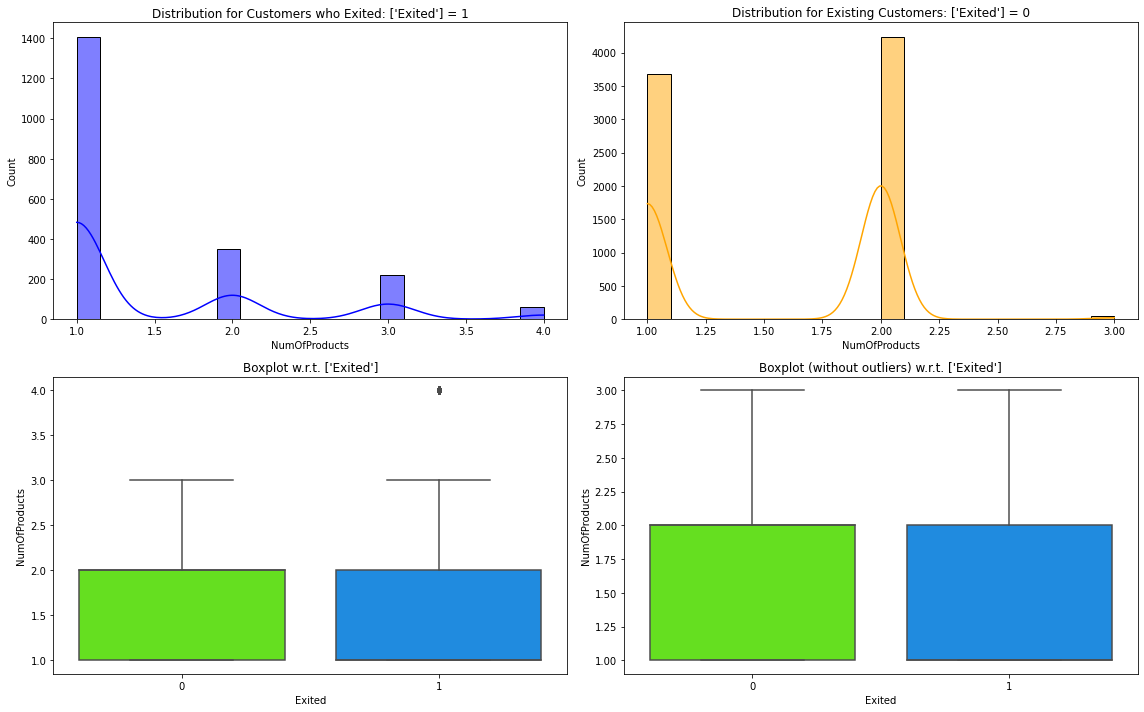

In [340]:
dist_plot_with_exited(df, 'NumOfProducts', 'Exited')

- Surprisingly only those who exited the bank had any customers with 4 bank products, while out of all the existing customers none have 4 bank products and barely any have 3 bank products.
- The number of customers with only 1 bank product is high for both existing customers and those who have left the bank.
- The biggest difference seems to be at those with 2 bank products. 2 products is the highest category for existing customers while a much lower portion of those who left the bank had 2 bank products.

###Balance vs. Exited

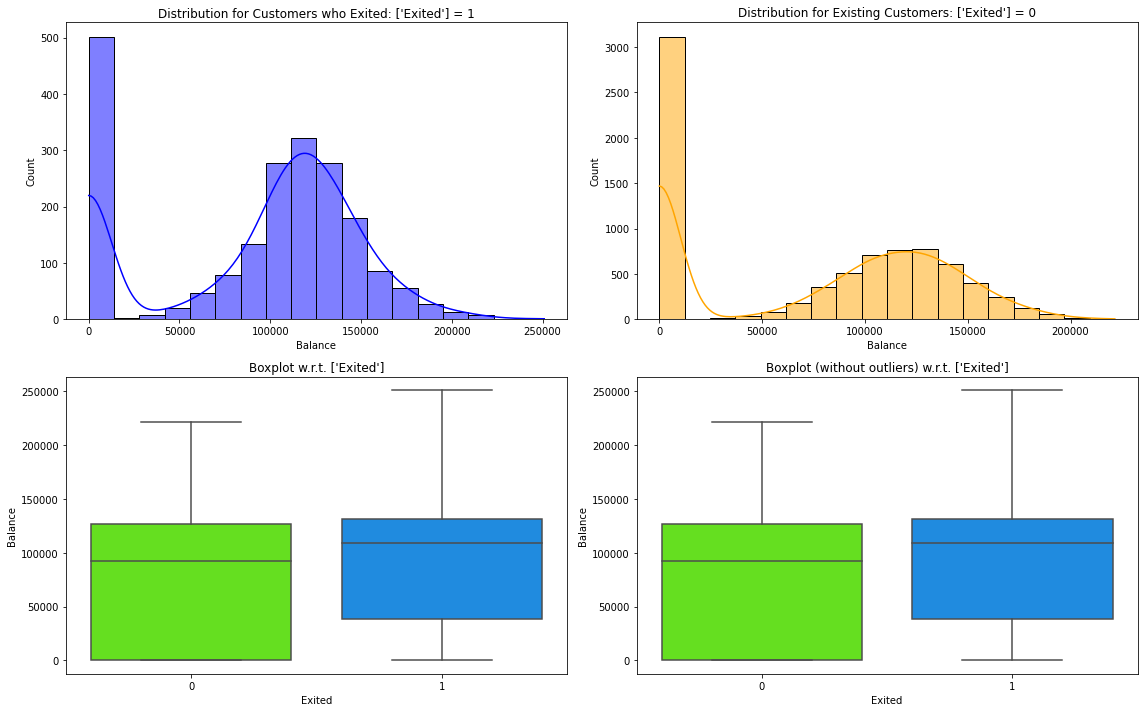

In [341]:
dist_plot_with_exited(df, 'Balance', 'Exited')

- A balance of 0 is the biggest category for both existing customers and those who have left.

###Estimated Salary vs. Exited

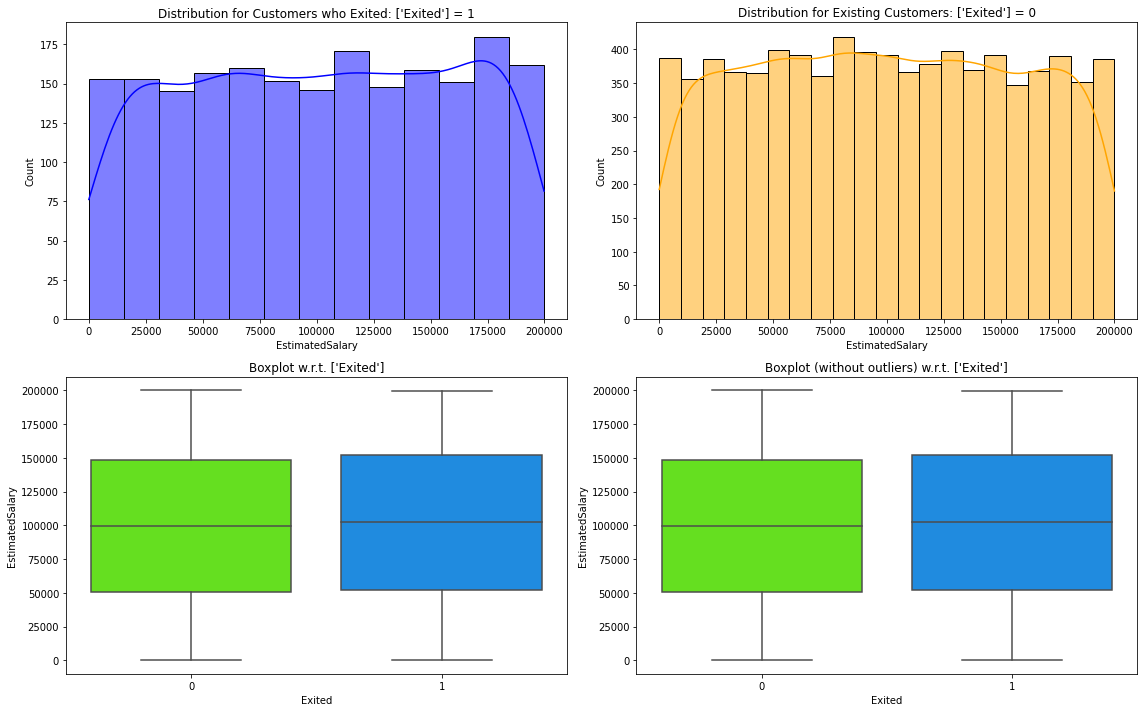

In [342]:
dist_plot_with_exited(df, 'EstimatedSalary', 'Exited')

- Estimated salary is spread fairly evenly along the whole range for both exiting customers and those have left the bank.

###Is Active Member vs. Exited

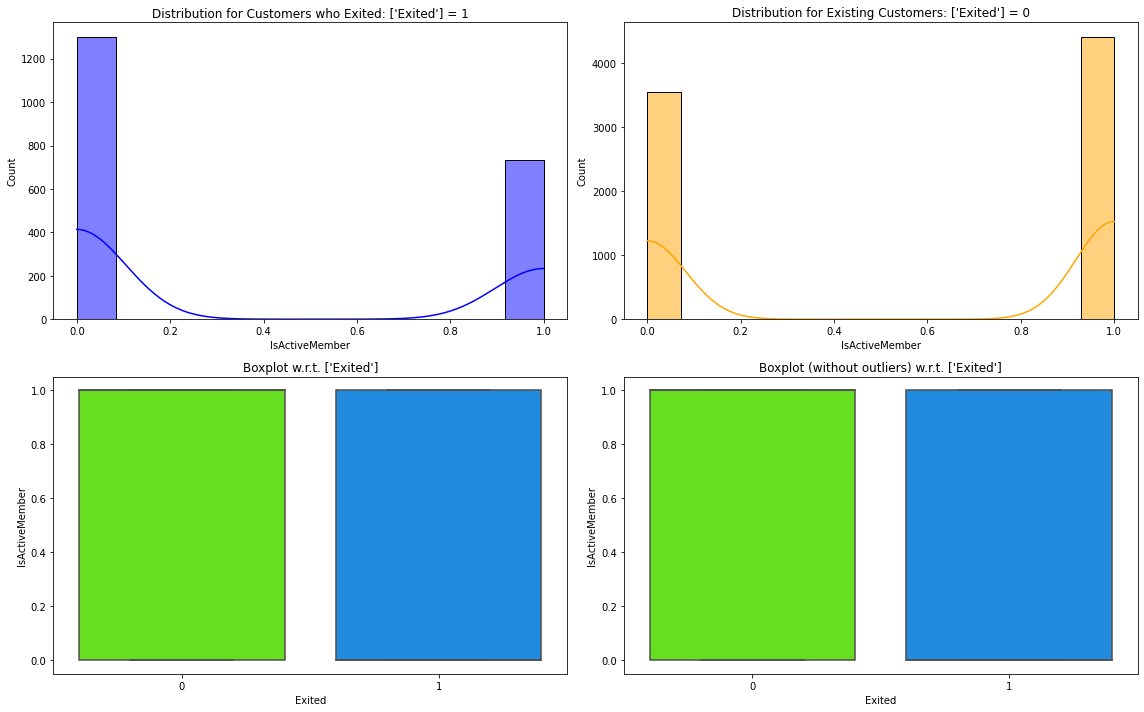

In [343]:
dist_plot_with_exited(df, 'IsActiveMember', 'Exited')

- A greater portion of those who exited the bank were not active members which makes sense.
- While active members are undestandably higher for existing customers the number is not much greater existing but inactive customers. These current but inactive customers could be at a risk of leaving the bank.

In [344]:
# function for stacked barplot

def stacked_bar(data, predictor, target):
    """
    plot stacked bar chart and print category counts

    data: df
    predictor: independent variable
    target: dependent variable ('Exited')
    """

    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print('*'*120)
    tab = pd.crosstab(data[predictor], data[target], normalize='index').sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind='bar', stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc='lower left',
        frameon=False
    )
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

###Geography vs. Exited

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
************************************************************************************************************************


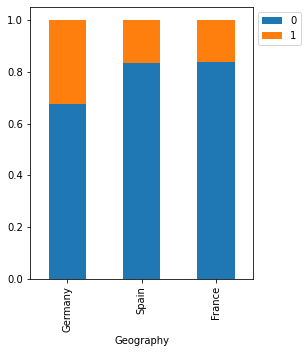

In [345]:
stacked_bar(df, 'Geography', 'Exited')

- France has over half of the customer base, but almost the same amount of customers exiting the bank as Germany, which has the least amount of customers, almost half as many as France.

###Gender vs. Exited

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
************************************************************************************************************************


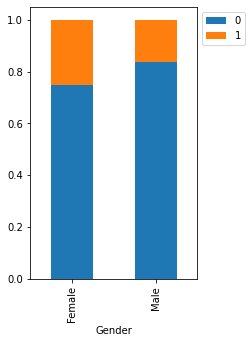

In [346]:
stacked_bar(df, 'Gender', 'Exited')

- There are slightly more males in the overall customer base, yet female customers are exiting the bank at a higher rate.

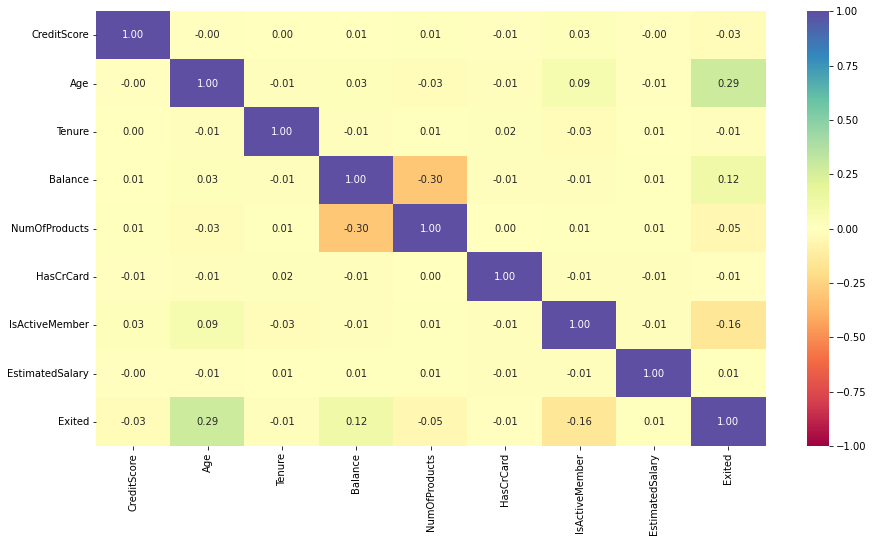

In [347]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')
plt.show()

- There does not appear to be any strong correlatin between variables.

#Summary of EDA

- Our dataset has 14 columns, 13 independent variables and 1 dependent variable. We dropped the columns for Row number, Customer Id, and Surname, leaving us 11 with 11 columns, 10 independent features, and 1 target feature.
- Exited is our target variable telling us whether or not a customer has left the bank. The value counts for Exited show that it's highly imbalanced with almost 4x as many customers remaining vs. those who exited. While this is good news for the bank retaining this many of the customers, it is not such great news for our model and its prediction accuracy. We will need to try out some sampling techniques in order to account for this imbalance.
- Nearly half of the customers in this dataset are considered not to be active members with the bank. This must be a concerning statistic to the bank and may be one of the main reasons they are trying to predict whether or not a customer will leave.
- Despite nearly half the customers being considered inactive, less than 1/4 of customers actually left the bank.
- About half of the customers in the dataset are in France, while the other half is split farily close between Germany and Spain. Despite France having twice as many customers as Germany they both have nearly the same amount of customers leaving the bank.
- A small but noteable aspect of credit score showed that no existing customers had less than a 400 credit score. Sub 400 scores were found exclusively amongst those customers who exited.
- There are a total of 4 bank products which customers may have, but almost all existing customers have only 1 or 2 products. Most of the customers with 3 bank products were found amoungst the exiting customers, and those with 4 products were only found in the customer group who left the bank. This is really curious as you would expect those with 3 or 4 products to be more active and invloved with the bank, therefore less likely to leave, yet the data appears to show the opposite being true.
- Gender has a fairly close split amongst the dataset, but there are more male customers than female customers. Despite there being more male customers in the dataset, there are more female customers who are leaving the bank.

#Data Preprocessing

Before we can start on building our models we need to split the data into train and test sets, perform One-hot encoding on our categorical variables, and then scale out data. We need to scale our data before model building with this dataset as there are very large scale differences between our independent variables so scaling them will help our model's predictions to be more accurate.

In [348]:
x = df.drop(['Exited'], axis=1)
y = df['Exited']

In [349]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9, stratify=y)

In [350]:
x_train = pd.get_dummies(x_train,columns= ['Geography', 'Gender'],drop_first =True)
x_test = pd.get_dummies(x_test,columns= ['Geography', 'Gender'],drop_first =True)

In [351]:
scaler = MinMaxScaler()

x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.transform(x_test)

In [352]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 11)
(2000, 11)
(8000,)
(2000,)


#Model Building
###A model can make wrong predictions in the following ways:
- Predicting a customer will leave the bank when they will not.
- Predicting a customer will remain a customer when they will actualy leave the bank.


###Which case is more important?
Both cases are important, as predicting a customer will leave, when they will actually stay, could mean a waste of company time and resources spent on trying to prevent the customer from leaving when they were never going anywhere in the first place. 

We will focus on F1-score since both scenarios are important for reducing the inccorect predictions in both of these cases.

###How to reduce this loss?
In order to prevent misidentifying customers as staying, when they will actually leave, and predicing a customer will leave when are not going anywhere,we need to recduce False Negatives and False Positives. We can achieve the greatest reduction in False Negatives and True Positves by maximizing the F1-score of our models.



###Model 1

In [353]:
backend.clear_session()
np.random.seed(9)
random.seed(9)
tf.random.set_seed(9)

In [354]:
# Initializing our neural network model
model = Sequential()
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', input_dim=11))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

In [355]:
adam=tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [356]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
_________________________________________________________________


In [357]:
history = model.fit(x_train_normalized, y_train, epochs=50, batch_size=64, verbose=1, validation_split=0.2)

Epoch 1/50
100/100 [==============================] - 1s 4ms/step - loss: 0.4652 - accuracy: 0.7958 - val_loss: 0.4427 - val_accuracy: 0.8000
Epoch 2/50
100/100 [==============================] - 0s 2ms/step - loss: 0.4396 - accuracy: 0.8127 - val_loss: 0.4286 - val_accuracy: 0.8150
Epoch 3/50
100/100 [==============================] - 0s 2ms/step - loss: 0.4215 - accuracy: 0.8177 - val_loss: 0.4145 - val_accuracy: 0.8213
Epoch 4/50
100/100 [==============================] - 0s 2ms/step - loss: 0.3996 - accuracy: 0.8311 - val_loss: 0.3847 - val_accuracy: 0.8431
Epoch 5/50
100/100 [==============================] - 0s 2ms/step - loss: 0.3824 - accuracy: 0.8373 - val_loss: 0.3764 - val_accuracy: 0.8456
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 0.3689 - accuracy: 0.8456 - val_loss: 0.3637 - val_accuracy: 0.8537
Epoch 7/50
100/100 [==============================] - 0s 2ms/step - loss: 0.3596 - accuracy: 0.8469 - val_loss: 0.3577 - val_accuracy: 0.8562
Epoch 

63/63 [==============================] - 0s 976us/step - loss: 43125.3242 - accuracy: 0.7715


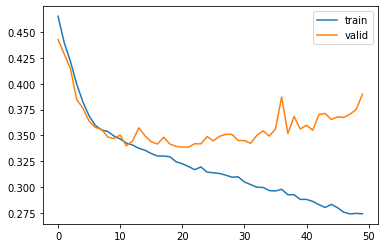

In [358]:
# capturing learning history per epoch
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(('train', 'valid'), loc=0)

# Printing Results
results = model.evaluate(x_test, y_test)

- These results are not encouraging. It appears there is a good deal of noise in out model and as there is such a big difference between the train and validation plots, we know that our model is also overfitting.
- We can try and improve the amount of noise as well as reduce overfitting in our next model.

In [359]:
y_pred=model.predict(x_test)
# creating a threshold of 0.5
y_pred= (y_pred > 0.5)
y_pred

63/63 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [360]:
# Creating a function to plot the confusion matrix for our model.

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabel=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Greens',
                          title=None,):

  # text inside each square
  blanks = ['' for i in range(cf.size)]

  if group_names and len(group_names)==cf.size:
      group_labels = ['{}\n'.format(value) for value in group_names]
  else:
    group_labels = blanks

  if count:
      group_counts = ['{0:0.0f}\n'.format(value) for value in cf.flatten()]
  else:
      group_counts = blanks

  if percent:
      group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
  else:
      group_percentages = blanks

  box_labels = [f'{v1}{v2}{v3}'.strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
  box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

  # Code to generate summary stats & text for summary stats
  if sum_stats:
      # Accuracy is sum of diagonal divided by total observations
      accuracy = np.trace(cf) / float(np.sum(cf))

  # Set figure parameters according to other arguments
  if figsize==None:
      # get default figure size if not set
      figsize = plt.rcParams.get('figure.figsize')

  if xyticks==False:
      # Do not show categories if xyticks is False
      categories=False

  # Make the heatmap
  plt.figure(figsize=figsize)
  sns.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

  if title:
      plt.title(title)

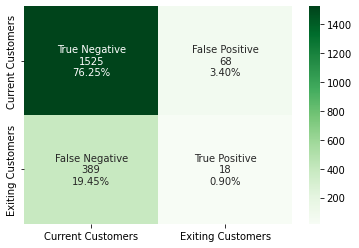

In [361]:
# generating confusion matrix
cm=confusion_matrix(y_test, y_pred)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

- While False Negatives are our lowest category in the confusion matrix the numbers are not good at all.  Currently our model is misclassifying 107 customers as staying when they are actually going to exit. Not attempting to save any of these customers well be very detrimental to the business.
- Since our dataset has an imbalance in our target class we will use the AOC-ROC curve to calulate the best threshold for our next model. For this model we just chose a mid level threshold of 0.5.

In [362]:
# Generate classification report
cr=metrics.classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1593
           1       0.21      0.04      0.07       407

    accuracy                           0.77      2000
   macro avg       0.50      0.50      0.47      2000
weighted avg       0.68      0.77      0.71      2000



###Model 2

In [367]:
backend.clear_session()
np.random.seed(9)
random.seed(9)
tf.random.set_seed(9)

In [368]:
# Initializing our ANN model with dropout, more neurons, and more layers
model2 = Sequential()
model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform', input_dim=x_train.shape[1]))
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(1, activation='sigmoid'))

- We can also try adjusting our learning rate to see if that improves things as well

In [369]:
adam=tf.keras.optimizers.Adam(lr=1e-3)
model2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [370]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3072      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4

- We can see here that we have increased the number of our parameters from 11,905 in our first model, to 50,497 for model2

- We also try doubling the amount of epochs to 100 to see if that helps to improve our model.

In [371]:
history2 = model2.fit(x_train_normalized, y_train, epochs=100, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/100
50/50 [==============================] - 1s 7ms/step - loss: 0.5268 - accuracy: 0.7831 - val_loss: 0.4848 - val_accuracy: 0.7981
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 0.4870 - accuracy: 0.7939 - val_loss: 0.4729 - val_accuracy: 0.7981
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 0.4786 - accuracy: 0.7955 - val_loss: 0.4621 - val_accuracy: 0.7975
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 0.4719 - accuracy: 0.7983 - val_loss: 0.4536 - val_accuracy: 0.8000
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 0.4696 - accuracy: 0.7966 - val_loss: 0.4649 - val_accuracy: 0.8019
Epoch 6/100
50/50 [==============================] - 0s 5ms/step - loss: 0.4623 - accuracy: 0.7986 - val_loss: 0.4586 - val_accuracy: 0.7962
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 0.4573 - accuracy: 0.8009 - val_loss: 0.4484 - val_accuracy: 0.8100
Epoch 8/100
5

63/63 [==============================] - 0s 1ms/step - loss: 20857.4180 - accuracy: 0.7845


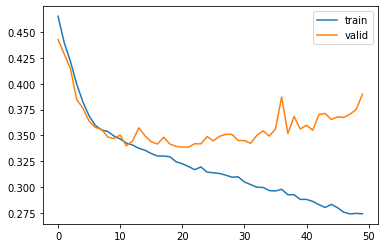

In [372]:
# capturing learning history per epoch
hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(('train', 'valid'), loc=0)

# Printing Results
results2 = model2.evaluate(x_test, y_test)

- Our model still has a significant amount of noise and the divergence between our train and validate curves has not seemed to improve.

In [409]:
y_pred2=model2.predict(x_test)
y_pred2 = (y_pred >0.5)
y_pred2

63/63 [==============================] - 0s 901us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

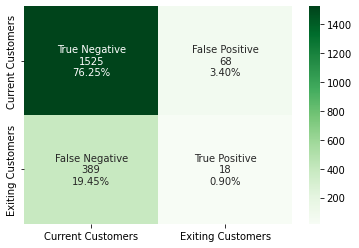

In [410]:
# generating confusion matrix
cm=confusion_matrix(y_test, y_pred2)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

- We now have true and false positive values being predicted again, but our false negative numbers are still pretty bad.
- Let's try adding batch normilation between layers to see if this helps to reduce our false negatives.
- We can also further adjust the number of neurons and layers in our model to see if that improves things.

In [411]:
# Generate classification report
cr2=metrics.classification_report(y_test, y_pred2)
print(cr2)

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1593
           1       0.21      0.04      0.07       407

    accuracy                           0.77      2000
   macro avg       0.50      0.50      0.47      2000
weighted avg       0.68      0.77      0.71      2000



###Model 3

In [377]:
backend.clear_session()
np.random.seed(9)
random.seed(9)
tf.random.set_seed(9)

In [378]:
# Initializing our ANN model3 with batch normilizationt, and adjustments to the number of neurons and layers
model3 = Sequential()
model3.add(Dense(128, activation='relu', kernel_initializer='he_uniform', input_dim=x_train.shape[1]))
model3.add(BatchNormalization())
model3.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model3.add(BatchNormalization())
model3.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dense(1, activation='sigmoid'))

In [379]:
adam=tf.keras.optimizers.Adam(lr=1e-3)
model3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [380]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1

- Witch batch normalization we now have 384 non=trainable parameters
- We also try significantly reducing our number of epochs

In [381]:
history3 = model3.fit(x_train_normalized, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4885 - accuracy: 0.7767 - val_loss: 0.4388 - val_accuracy: 0.8163
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4105 - accuracy: 0.8280 - val_loss: 0.3814 - val_accuracy: 0.8406
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3765 - accuracy: 0.8408 - val_loss: 0.3672 - val_accuracy: 0.8469
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3668 - accuracy: 0.8431 - val_loss: 0.3609 - val_accuracy: 0.8537
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3582 - accuracy: 0.8500 - val_loss: 0.3637 - val_accuracy: 0.8537
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3491 - accuracy: 0.8528 - val_loss: 0.3560 - val_accuracy: 0.8556
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3516 - accuracy: 0.8528 - val_loss: 0.3555 - val_accuracy: 0.8481
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 182854.6719 - accuracy: 0.2080


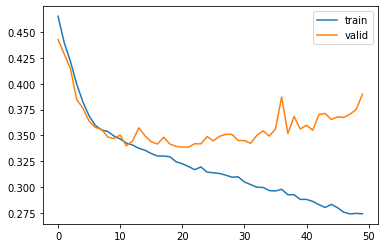

In [382]:
# capturing learning history per epoch
hist3 = pd.DataFrame(history3.history)
hist3['epoch'] = history3.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(('train', 'valid'), loc=0)

# Printing Results
results3 = model3.evaluate(x_test, y_test)

63/63 [==============================] - 0s 1ms/step
Best Threshold=1.000000, G-mean=0.090


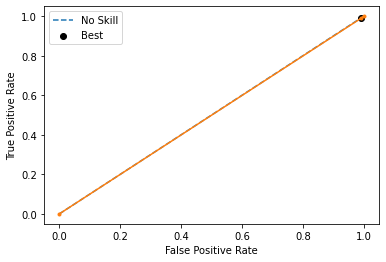

In [383]:
# predict probabilities
yhat3=model3.predict(x_test)
# keep probabilities for the positive outcome only
yhat3=yhat3[:, 0]
# calculate roc curves
fpr, tpr, threshold3 = roc_curve(y_test, yhat3)
# calculate the g-mean for each threshold
gmeans3 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans3)
print('Best Threshold=%f, G-mean=%.3f' % (threshold3[ix], gmeans3[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [384]:
y_pred_roc3=model3.predict(x_test)
y_pred_roc3 = (y_pred_roc3 > threshold3[ix])
y_pred_roc3

63/63 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

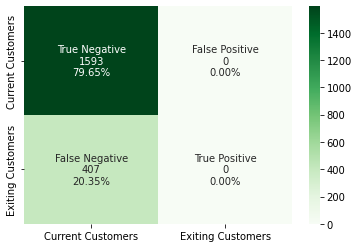

In [385]:
# generating confusion matrix
cm=confusion_matrix(y_test, y_pred_roc3)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

In [386]:
# Generate classification report
cr3=metrics.classification_report(y_test, y_pred_roc3)
print(cr3)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



###Model 4

In [387]:
backend.clear_session()
np.random.seed(9)
random.seed(9)
tf.random.set_seed(9)

In [388]:
def create_model_CV(lr, batch_size):
    np.random.seed(9)
    model_CV = Sequential()
    model_CV.add(Dense(256, activation='relu', input_dim= x_train.shape[1]))
    model_CV.add(Dropout(0.3))
    model_CV.add(Dense(128, activation='relu'))
    model_CV.add(Dropout(0.3))
    model_CV.add(Dense(64, activation='relu'))
    model_CV.add(Dropout(0.2))
    model_CV.add(Dense(32, activation='relu'))
    model_CV.add(Dense(1, activation='sigmoid'))

    # compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model_CV.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model_CV

In [389]:
keras_estimator = KerasClassifier(build_fn=create_model_CV, verbose=1)
# define grid search parameters
param_random = {
    'batch_size':[32,64,128],
    'lr':[0.01, 0.1, 0.001],}

kfold_splits = 3 
random_CV= RandomizedSearchCV(estimator=keras_estimator,
                           verbose=1,
                           cv=kfold_splits,
                           param_distributions=param_random, n_jobs=1)

In [390]:
random_result = random_CV.fit(x_train_normalized, y_train, validation_split=0.2, verbose=1)

# summarize results
print('Best: %f using %s' % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Fitting 3 folds for each of 9 candidates, totalling 27 fits
200/200 [==============================] - 1s 3ms/step - loss: 0.4887 - accuracy: 0.7958 - val_loss: 0.4613 - val_accuracy: 0.7981
Best: 0.797250 using {'lr': 0.01, 'batch_size': 32}


In [391]:
estimator_CV=create_model_CV(batch_size=random_result.best_params_['batch_size'], lr=random_result.best_params_['lr'])

estimator_CV.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 256)               3072      
                                                                 
 dropout_84 (Dropout)        (None, 256)               0         
                                                                 
 dense_141 (Dense)           (None, 128)               32896     
                                                                 
 dropout_85 (Dropout)        (None, 128)               0         
                                                                 
 dense_142 (Dense)           (None, 64)                8256      
                                                                 
 dropout_86 (Dropout)        (None, 64)                0         
                                                                 
 dense_143 (Dense)           (None, 32)              

In [392]:
optimizer = tf.keras.optimizers.Adam(random_result.best_params_['lr'])
estimator_CV.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_4=estimator_CV.fit(x_train, y_train, epochs=50, batch_size= 64, verbose=1, validation_split=0.2)

Epoch 1/50
100/100 [==============================] - 1s 4ms/step - loss: 277.7027 - accuracy: 0.6711 - val_loss: 4.2392 - val_accuracy: 0.3844
Epoch 2/50
100/100 [==============================] - 0s 3ms/step - loss: 4.5959 - accuracy: 0.6841 - val_loss: 0.8184 - val_accuracy: 0.7731
Epoch 3/50
100/100 [==============================] - 0s 3ms/step - loss: 2.0731 - accuracy: 0.6988 - val_loss: 0.5375 - val_accuracy: 0.7981
Epoch 4/50
100/100 [==============================] - 0s 3ms/step - loss: 1.1353 - accuracy: 0.7287 - val_loss: 0.5033 - val_accuracy: 0.7981
Epoch 5/50
100/100 [==============================] - 0s 3ms/step - loss: 0.8797 - accuracy: 0.7553 - val_loss: 0.5439 - val_accuracy: 0.7719
Epoch 6/50
100/100 [==============================] - 0s 3ms/step - loss: 0.7334 - accuracy: 0.7634 - val_loss: 0.5021 - val_accuracy: 0.7981
Epoch 7/50
100/100 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.7769 - val_loss: 0.5013 - val_accuracy: 0.7981
Epoc

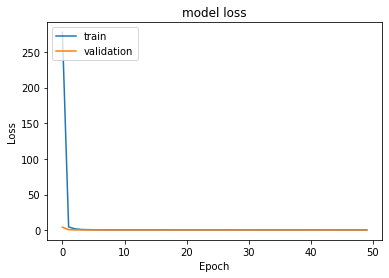

In [393]:
# Plotting Train Loss vs. Validation Loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 1ms/step
Best Threshold=1.201201, G-mean=0.000


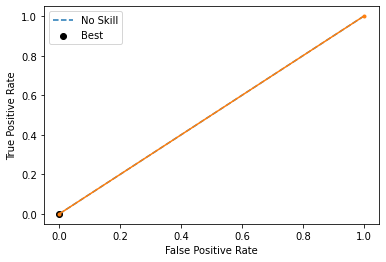

In [394]:
# predict probabilities
yhat4 = estimator_CV.predict(x_test)
# keep probabilities for the positive outcome only
yhat4 = yhat4[:, 0]
# calculates roc curves
fpr, tpr, threshold4 = roc_curve(y_test, yhat4)
# calculates the g-mean for each threshold
gmeans4 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans4)
print('Best Threshold=%f, G-mean=%.3f' % (threshold4[ix], gmeans4[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [395]:
y_pred_roc4=estimator_CV.predict(x_test)
y_pred_roc4 = (y_pred_roc4 > threshold4[ix])
y_pred_roc4

63/63 [==============================] - 0s 957us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

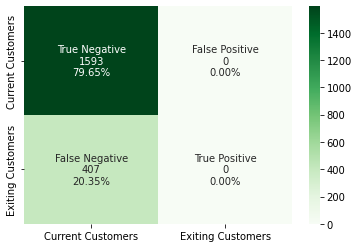

In [396]:
# generating confusion matrix
cm=confusion_matrix(y_test, y_pred_roc4)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

In [397]:
# Accuracy as per the classification report
from sklearn import metrics
cr4=metrics.classification_report(y_test, y_pred_roc4)
print(cr4)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



###Model 5

In [398]:
backend.clear_session()
np.random.seed(9)
random.seed(9)
tf.random.set_seed(9)

In [399]:
def create_model_grid(lr, batch_size):
    np.random.seed(1337)
    model_grid = Sequential()
    model_grid.add(Dense(256, activation='relu', input_dim= x_train.shape[1]))
    model_grid.add(Dropout(0.3))
    model_grid.add(Dense(128, activation='relu'))
    model_grid.add(Dropout(0.3))
    model_grid.add(Dense(64, activation='relu'))
    model_grid.add(Dropout(0.2))
    model_grid.add(Dense(32, activation='relu'))
    model_grid.add(Dense(1, activation='sigmoid'))

    # compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model_grid.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model_grid

In [400]:
keras_estimator = KerasClassifier(build_fn=create_model_grid, verbose=1)
# define grid search parameters
param_grid = {
    'batch_size':[64,32,128],
    'lr':[0.01, 0.1, 0.001],}

kfold_splits = 3 
grid = GridSearchCV(estimator=keras_estimator,
                           verbose=1,
                           cv=kfold_splits,
                           param_grid=param_grid, n_jobs=1)

In [401]:
import time

# store starting time
begin = time.time()

grid_result = grid.fit(x_train, y_train, validation_split=0.2, verbose=1)

# summarize results
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

time.sleep(1)

#store end time
end = time.time()

# total time taken
print(f'Total runtime of the program is {end - begin}')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
100/100 [==============================] - 1s 4ms/step - loss: 6702.5908 - accuracy: 0.7719 - val_loss: 0.5030 - val_accuracy: 0.7981
Best: 0.796250 using {'batch_size': 64, 'lr': 0.1}
Total runtime of the program is 32.858338832855225


In [402]:
estimator_grid=create_model_grid(batch_size=grid_result.best_params_['batch_size'], lr=grid_result.best_params_['lr'])

estimator_grid.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 256)               3072      
                                                                 
 dropout_84 (Dropout)        (None, 256)               0         
                                                                 
 dense_141 (Dense)           (None, 128)               32896     
                                                                 
 dropout_85 (Dropout)        (None, 128)               0         
                                                                 
 dense_142 (Dense)           (None, 64)                8256      
                                                                 
 dropout_86 (Dropout)        (None, 64)                0         
                                                                 
 dense_143 (Dense)           (None, 32)              

In [403]:
optimizer = tf.keras.optimizers.Adam(grid_result.best_params_['lr'])
estimator_grid.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_5=estimator_grid.fit(x_train, y_train, epochs=50, batch_size= 64, verbose=1, validation_split=0.2)

Epoch 1/50
100/100 [==============================] - 1s 8ms/step - loss: 5617.5239 - accuracy: 0.7705 - val_loss: 0.5029 - val_accuracy: 0.7981
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 0.5073 - accuracy: 0.7958 - val_loss: 0.5027 - val_accuracy: 0.7981
Epoch 3/50
100/100 [==============================] - 0s 3ms/step - loss: 0.5064 - accuracy: 0.7958 - val_loss: 0.5046 - val_accuracy: 0.7981
Epoch 4/50
100/100 [==============================] - 0s 3ms/step - loss: 0.5085 - accuracy: 0.7958 - val_loss: 0.5044 - val_accuracy: 0.7981
Epoch 5/50
100/100 [==============================] - 0s 3ms/step - loss: 0.5072 - accuracy: 0.7958 - val_loss: 0.5029 - val_accuracy: 0.7981
Epoch 6/50
100/100 [==============================] - 0s 3ms/step - loss: 0.5071 - accuracy: 0.7958 - val_loss: 0.5039 - val_accuracy: 0.7981
Epoch 7/50
100/100 [==============================] - 0s 3ms/step - loss: 0.5081 - accuracy: 0.7958 - val_loss: 0.5061 - val_accuracy: 0.7981
Epo

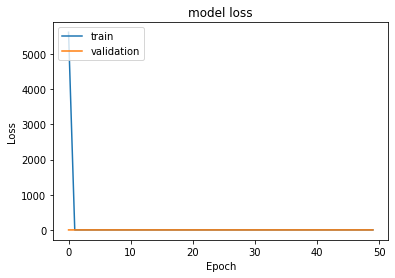

In [404]:
# Plotting Train Loss vs. Validation Loss
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 2ms/step
Best Threshold=1.191940, G-mean=0.000


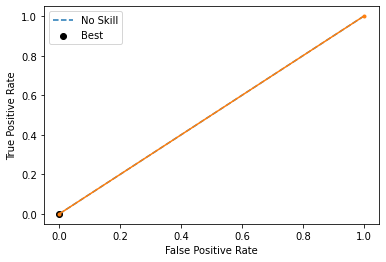

In [405]:
# predict probabilities
yhat5 = estimator_grid.predict(x_test)
# keep probabilities for the positive outcome only
yhat5 = yhat5[:, 0]
# calculates roc curves
fpr, tpr, thresholds5 = roc_curve(y_test, yhat5)
# calculates the g-mean for each threshold
gmeans5 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans5)
print('Best Threshold=%f, G-mean=%.3f' % (thresholds5[ix], gmeans5[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [406]:
y_pred_roc5=estimator_grid.predict(x_test)
y_pred_roc5 = (y_pred_roc5 > thresholds5[ix])
y_pred_roc5

63/63 [==============================] - 0s 949us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

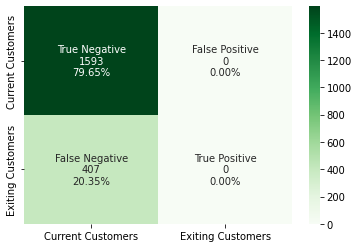

In [407]:
# generating confusion matrix
cm=confusion_matrix(y_test, y_pred_roc5)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

#Summary

Overall our models were not great. We were not getting good threshold values for ROC-AUC curves.  Our best results came just using a default threshold value of 0.5, but even with this threshold our model was still predicting 389 customers who were actually leaving would stay customers. Obviously we could have much better results and better threshold values would play a big part in that.



# Business Reccomendations

I don't have specific reccomendations for the how the business should proceed as my models were not great, but I do have reccomendations on how results could possibly be improved in order to create a better model.

- They could try using a sampling technique like over or under sampling before creating the models since the target variable was imbalanced. This may be able to improve results.

- They could also try implementing a machine learning model 1st in order to identify which features are most important and then build an improved neural network using only those key features.

- I would not reccomend they implement any of these neural networks as the results would not be good enough for what they are trying to achieve.

In [412]:
!jupyter nbconvert --to html /content/Jonathan_Hutcheson_Credit_Churn_Prediction.ipynb

[NbConvertApp] WARNING | pattern '/content/Jonathan_Hutcheson_Credit_Churn_Prediction.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--J